<a href="https://colab.research.google.com/github/simon-m-mudd/random_fun_notebooks/blob/main/fit_file_viz.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install fitparse pandas

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.7/65.7 kB 2.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for fitparse: filename=fitparse-1.2.0-py3-none-any.whl size=68214 sha256=3d2225d6ea5b527ac135b7883fd687170c41bfa99c0fae7465d486c685e1c1ed
  Stored in directory: /root/.cache/pip/wheels/54/14/72/b54dcabc07cc3ef598e897698d9018a63acbeb6adac1cdf6d5
Successfully built fitparse


In [11]:
import os
import fitparse
import pandas as pd
import matplotlib.pyplot as plt

def find_fit_files(directory):
    """
    Searches the specified directory for all files with the .fit extension and returns a list of their filenames.

    Parameters:
    directory (str): The directory to search for .fit files.

    Returns:
    list: A list of filenames with the .fit extension.
    """
    fit_files = [f for f in os.listdir(directory) if f.endswith('.fit')]
    return fit_files

import os
import pandas as pd
import matplotlib.pyplot as plt
from fitparse import FitFile

def find_fit_files(directory):
    """
    Searches the specified directory for all files with the .fit extension and returns a list of their filenames.

    Parameters:
    directory (str): The directory to search for .fit files.

    Returns:
    list: A list of filenames with the .fit extension.
    """
    fit_files = [f for f in os.listdir(directory) if f.endswith('.fit')]
    return fit_files

def read_fit_file(file_path):
    """
    Reads a .fit file and returns a DataFrame with the relevant data.

    Parameters:
    file_path (str): The path to the .fit file.

    Returns:
    pd.DataFrame: DataFrame containing the relevant data.
    """
    fitfile = FitFile(file_path)
    data = []

    for record in fitfile.get_messages('record'):
        record_data = {}
        for data_point in record:
            record_data[data_point.name] = data_point.value
        data.append(record_data)

    df = pd.DataFrame(data)
    df['elapsed_time'] = (df['timestamp'] - df['timestamp'][0]).dt.total_seconds() / 60.0
    return df[['elapsed_time', 'heart_rate', 'cadence', 'power', 'altitude']]

def plot_activity(df):
    """
    Plots the activity data with separate vertical axes for heart rate, cadence, and power, and a filled plot for altitude.

    Parameters:
    df (pd.DataFrame): DataFrame containing the activity data.
    """
    fig, ax1 = plt.subplots(figsize=(16, 8))

    ax1.set_xlabel('Elapsed Time (minutes)', fontsize=24)
    ax1.set_ylabel('Heart Rate (bpm)', color='red', fontsize=24)
    ax1.plot(df['elapsed_time'], df['heart_rate'], color='red', label='Heart Rate')
    ax1.tick_params(axis='y', labelcolor='red', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Cadence (rpm)', color='blue', fontsize=24)
    ax2.plot(df['elapsed_time'], df['cadence'], color='blue', label='Cadence')
    ax2.tick_params(axis='y', labelcolor='blue', labelsize=20)

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('Power (watts)', color='black', fontsize=24)
    ax3.plot(df['elapsed_time'], df['power'], color='black', label='Power')
    ax3.tick_params(axis='y', labelcolor='black', labelsize=20)

    fig.tight_layout()
    plt.title('Activity Data', fontsize=28)
    plt.show()

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.fill_between(df['elapsed_time'], df['altitude'], color='green', alpha=0.9)
    ax.set_xlabel('Elapsed Time (minutes)', fontsize=24)
    ax.set_ylabel('Altitude (meters)', fontsize=24)
    ax.set_ylim(df['altitude'].min(), df['altitude'].max())
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    plt.title('Altitude Data', fontsize=28)
    plt.show()

def plot_activity_with_range(df, min_time, max_time):
    """
    Plots the activity data within a specified time range with separate vertical axes for heart rate, cadence, and power, and a filled plot for altitude.

    Parameters:
    df (pd.DataFrame): DataFrame containing the activity data.
    min_time (float): Minimum elapsed time in minutes.
    max_time (float): Maximum elapsed time in minutes.
    """
    df_range = df[(df['elapsed_time'] >= min_time) & (df['elapsed_time'] <= max_time)]

    mean_power = df_range['power'].mean()
    median_power = df_range['power'].median()
    mean_cadence = df_range['cadence'].mean()
    median_cadence = df_range['cadence'].median()

    fig, ax1 = plt.subplots(figsize=(16, 8))

    ax1.set_xlabel('Elapsed Time (minutes)', fontsize=24)
    ax1.set_ylabel('Heart Rate (bpm)', color='red', fontsize=24)
    ax1.plot(df_range['elapsed_time'], df_range['heart_rate'], color='red', label='Heart Rate')
    ax1.tick_params(axis='y', labelcolor='red', labelsize=20)
    ax1.tick_params(axis='x', labelsize=20)

    ax2 = ax1.twinx()
    ax2.set_ylabel('Cadence (rpm)', color='blue', fontsize=24)
    ax2.plot(df_range['elapsed_time'], df_range['cadence'], color='blue', label='Cadence')
    ax2.tick_params(axis='y', labelcolor='blue', labelsize=20)

    ax3 = ax1.twinx()
    ax3.spines['right'].set_position(('outward', 60))
    ax3.set_ylabel('Power (watts)', color='black', fontsize=24)
    ax3.plot(df_range['elapsed_time'], df_range['power'], color='black', label='Power')
    ax3.tick_params(axis='y', labelcolor='black', labelsize=20)

    fig.tight_layout()
    plt.title('Activity Data', fontsize=28)
    plt.text(0.5, 1.05, f'Mean Power: {mean_power:.2f} W, Median Power: {median_power:.2f} W, Mean Cadence: {mean_cadence:.2f} rpm, Median Cadence: {median_cadence:.2f} rpm',
             transform=ax1.transAxes, fontsize=24, ha='center')
    plt.show()

    fig, ax = plt.subplots(figsize=(16, 8))
    ax.fill_between(df_range['elapsed_time'], df_range['altitude'], color='green', alpha=0.9)
    ax.set_xlabel('Elapsed Time (minutes)', fontsize=24)
    ax.set_ylabel('Altitude (meters)', fontsize=24)
    ax.set_ylim(df['altitude'].min(), df['altitude'].max())
    ax.tick_params(axis='x', labelsize=20)
    ax.tick_params(axis='y', labelsize=20)
    plt.title('Altitude Data', fontsize=28)
    plt.show()


# Example usage:
# df = read_fit_file('your_file.fit')
# plot_activity(df)
# plot_activity_with_range(df, min_time=10, max_time=30)





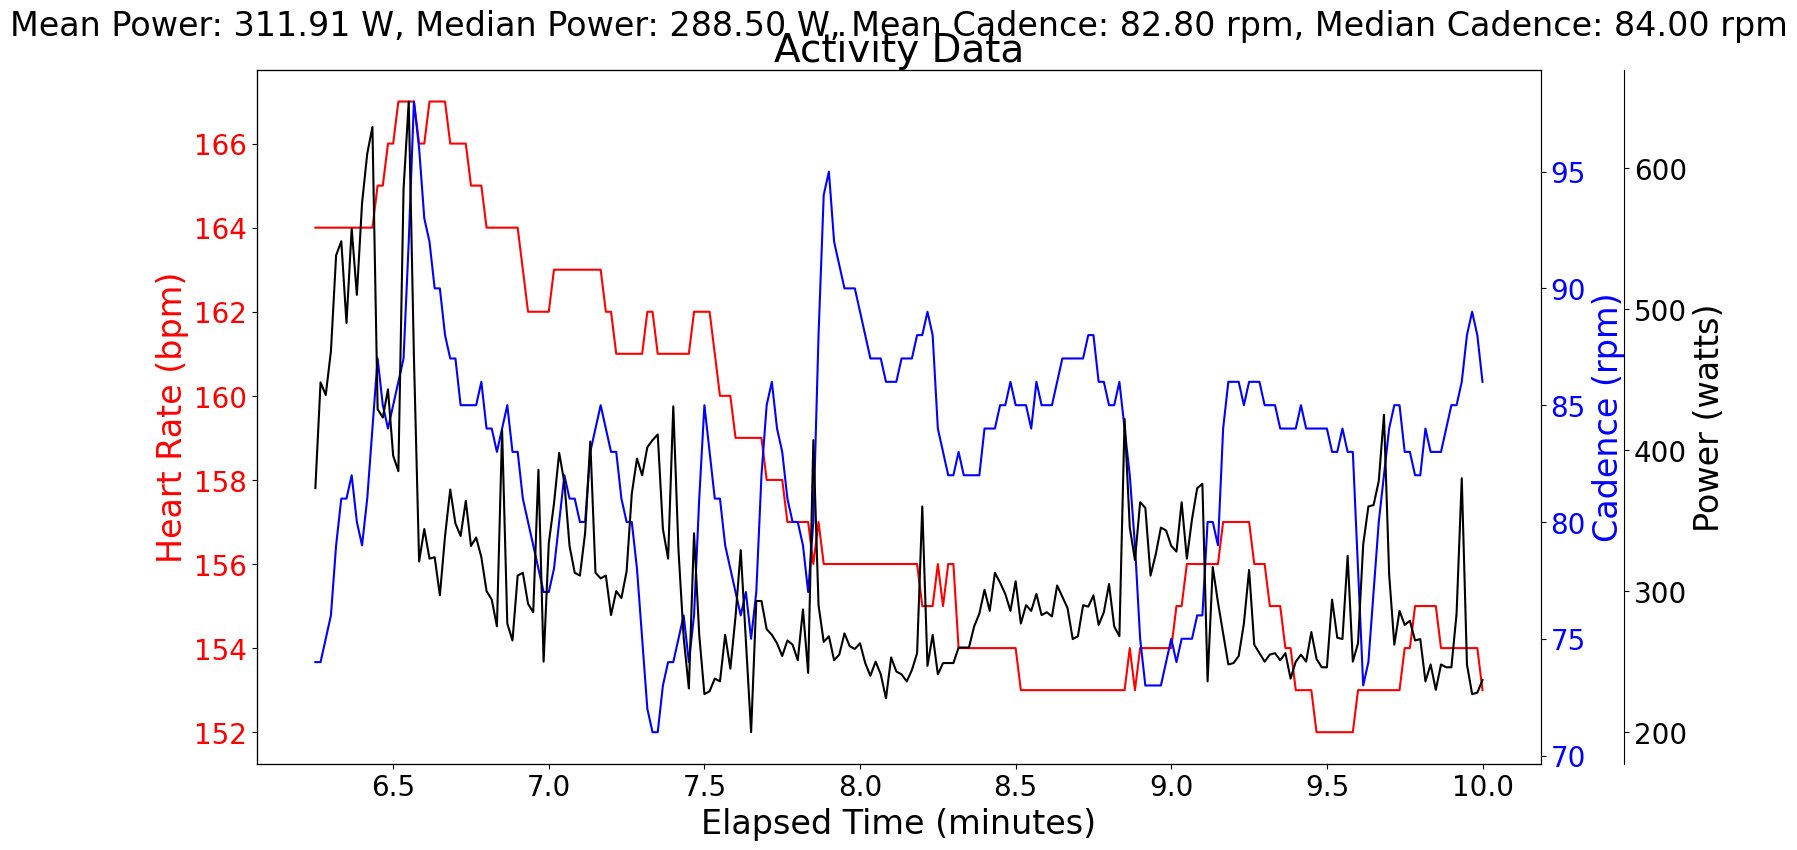

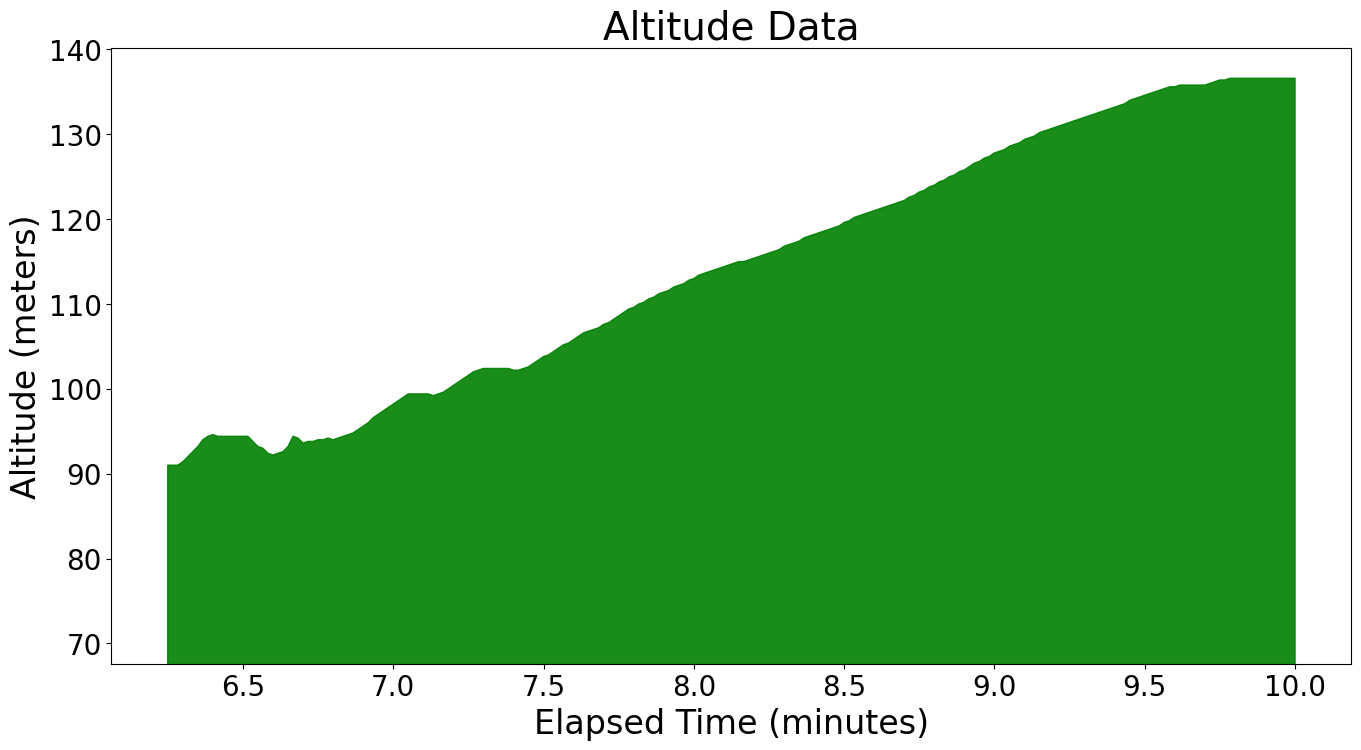

In [16]:

# Example usage
fit_files = find_fit_files('.')  # Searches the current directory
if fit_files:
    df = read_fit_file(fit_files[0])  # Reads the first .fit file found
    #plot_activity(df)
    plot_activity_with_range(df, min_time=6.25, max_time=10)
else:
    print("No .fit files found in the directory.")

# Example usage:
# df = read_fit_file('your_file.fit')
# plot_activity(df)
# plot_activity_with_range(df, min_time=10, max_time=30)
